<a href="https://colab.research.google.com/github/s-jainr/deep-learning-sp23/blob/main/Copy_of_07_AIT_CNN_transfer_learning_Keras_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright
<pre>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.

Paper about Inception V3 model: 
https://arxiv.org/abs/1512.00567

Sources used during preparation of this notebook:
https://keras.io/applications/
https://gist.github.com/fchollet/7eb39b44eb9e16e59632d25fb3119975
https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb

Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
</pre>

# Transfer learning

Transfer learning means that a trained network is trained further with additional data and possibly a custom goal.

## Downloading and loading the data

We will use the dogs and cats dataset from https://www.kaggle.com/c/dogs-vs-cats. You can download a fraction of the dataset from https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip.

In [1]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O /tmp/cats_and_dogs_filtered.zip

--2023-04-06 13:07:52--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M  19.5MB/s    in 4.5s    

2023-04-06 13:07:57 (14.6 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
!apt-get install unp > /dev/null

In [3]:
!unp /tmp/cats_and_dogs_filtered.zip > /dev/null

Next, we define the names of the directories for training and validation data:


In [4]:
import os
base_dir = 'cats_and_dogs_filtered' 
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Let's list some files from the directories:


In [5]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort()
print(train_dog_fnames[:10])

['cat.293.jpg', 'cat.880.jpg', 'cat.433.jpg', 'cat.421.jpg', 'cat.536.jpg', 'cat.973.jpg', 'cat.758.jpg', 'cat.790.jpg', 'cat.688.jpg', 'cat.659.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


Let's investigate some example photos from the dataset:

In [6]:
train_cat_fnames[:10]

['cat.293.jpg',
 'cat.880.jpg',
 'cat.433.jpg',
 'cat.421.jpg',
 'cat.536.jpg',
 'cat.973.jpg',
 'cat.758.jpg',
 'cat.790.jpg',
 'cat.688.jpg',
 'cat.659.jpg']

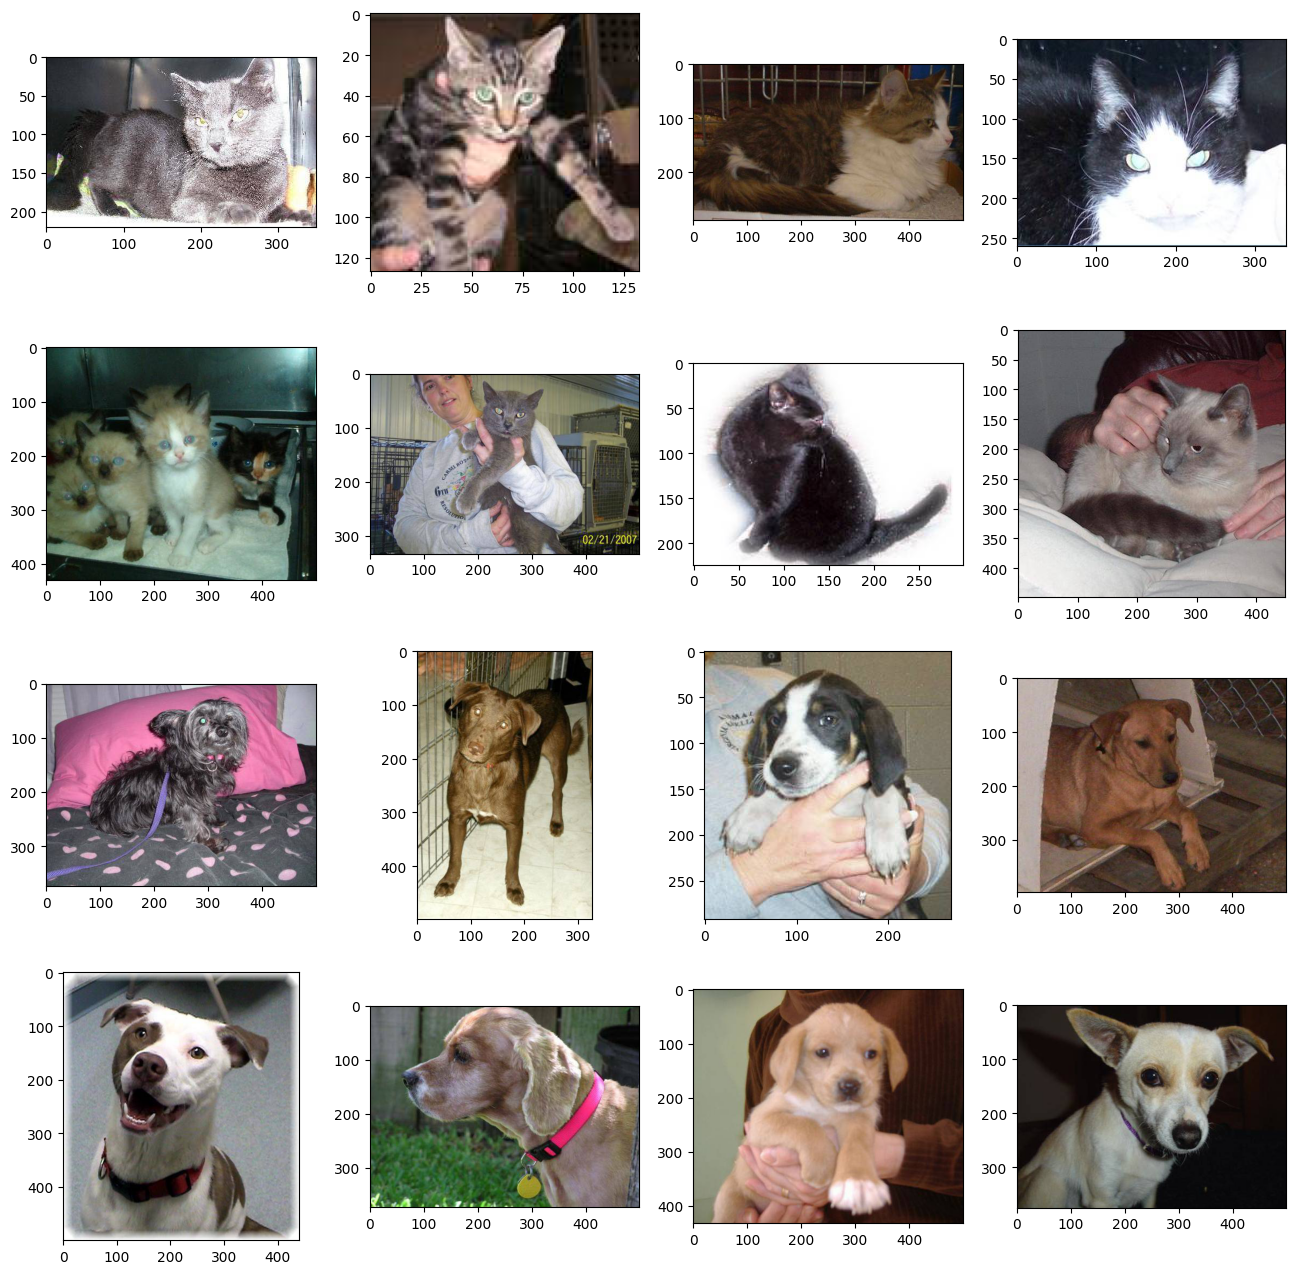

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_cat_pix = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[:int(ncols*nrows/2)]]
next_dog_pix = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[:int(ncols*nrows/2)]]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

## Loading a pretrained network and training it further (transfer learning)

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input,decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as K
import numpy as np

In [9]:
img_height=299
img_width=299

In [10]:
# loading the pretrained Inception V3, without fully-connected layers
base_model = InceptionV3(weights='imagenet', include_top=False)
# Global Average Pooling is a pooling layer, that reshapes the data into 2D, which can be used 
# as input for further dense layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Adding a dense layer with ReLU
x = Dense(1024, activation='relu')(x)
# and finally the output layer for binary classification with a single output and sigmoid activation
predictions = Dense(1, activation='sigmoid')(x)
# defining the model
model = Model(inputs=base_model.input, outputs=predictions)

87910968/87910968 [==============================] - 5s 0us/step


We train the network in two steps. First, we train the upper dense layers, and while the convolutional layers are 'freezed':

In [11]:
for layer in base_model.layers:
    layer.trainable = False

# compiling the model after freezing the convolutional layers
model.compile(optimizer='adam', metrics=['accuracy'],loss='binary_crossentropy')

In [12]:
# using generators to load the images
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')
validation_generator = valid_datagen.flow_from_directory(validation_dir, target_size=(img_height, img_width), batch_size=20, class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
# this function trains the model, while using the datagenerators
# please note, that data augmentation is also performed, while training the network
model.fit(train_generator,steps_per_epoch=200,validation_data=validation_generator,validation_steps=10,epochs=3)

Epoch 1/3
100/200 [==============>...............] - ETA: 45s - loss: 0.1176 - accuracy: 0.9570

200/200 [==============================] - 63s 242ms/step - loss: 0.1176 - accuracy: 0.9570 - val_loss: 0.0661 - val_accuracy: 0.9900


In the following part we will take the 2nd step: we will unfreeze the upper convolutional layers of Inception V3.

In [14]:
print("The convolutional part of Inception V3:")
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

The convolutional part of Inception V3:
0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_norm

## Exercise

Freeze everything below layer conv2d_56 (including conv2d_56): 

In [16]:
for layer in base_model.layers[:173]:
       layer.trainable = False
for layer in base_model.layers[173:]:
       layer.trainable = True

Recompiling the model, this time with SGD optimizer, small learning rate (0.0001) and with a momentum (0.9). 

In [24]:
model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), metrics=['accuracy'], loss='binary_crossentropy')

And train the model further, as we did before, and inspect the loss and accuracy:

In [25]:
model.fit_generator(train_generator,steps_per_epoch=200,validation_data=validation_generator,validation_steps=10,epochs=3)

<ipython-input-25-321100b519ef>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,steps_per_epoch=200,validation_data=validation_generator,validation_steps=10,epochs=3)


Epoch 1/3
100/200 [==============>...............] - ETA: 45s - loss: 0.0273 - accuracy: 0.9910

200/200 [==============================] - 61s 241ms/step - loss: 0.0273 - accuracy: 0.9910 - val_loss: 0.0089 - val_accuracy: 1.0000


NameError: ignored